In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
# load training and testing set
# define shuffle data loader?
# got csv files from https://pjreddie.com/projects/mnist-in-csv/
HOME="/home/adsgray"
DIR=HOME + "/code/mnist"
TRAINING=DIR + "/mnist_train.csv"
TESTING=DIR + "/mnist_test.csv"



In [204]:
trainingfile = open(TRAINING, "r")
testingfile = open(TESTING, "r")
traininglines = trainingfile.readlines()
testinglines = testingfile.readlines()

def tensor_from_string(s):
    l = [int(i) for i in s.split(",")]
    #map(int, l)
    return tensor(l)

    
training_raw = torch.stack([tensor_from_string(s) for s in traininglines])
testing_raw = torch.stack([tensor_from_string(s) for s in testinglines])



In [391]:

training_labels = training_raw[:,0]
training_images = training_raw[:,1:].float()/255

testing_labels = testing_raw[:,0]
testing_images = testing_raw[:,1:].float()/255
#show_image(t[0].view(28,28))
#testing_labels[59]
#show_image(testing_images[59].view(28,28))

testing_images.shape[0]

10000

In [250]:
# functions to select a random sample
import random

def random_indexes(num, max):
    return [random.randrange(0,max) for i in range(num)]

def training_sample(num):
    max = training_images.shape[0]
    idxs = random_indexes(num, max)
    return [(training_images[idxs], training_labels[idxs])]



In [449]:
# define cost function

from torch import exp
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
def sigmoid(x): return 1/(1+torch.exp(-x))

fudge=1.

def mnist_loss(predictions, targets):
    return F.nll_loss(F.log_softmax(predictions, dim=1), targets)

    
def mnist_loss2(predictions, targets):
    lp = torch.log(predictions)
    sm = softmax(lp)
    #print("sm: ", sm)
    predictions = -sm
    #predictions = softmax(predictions)
    return predictions[range(targets.shape[0]), targets].mean()
   

In [644]:
# initialize parameters
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()


width=400
w1 = init_params((28*28,width))
b1 = init_params(width)
w2 = init_params((width,10))
b2 = init_params(10)

params = (w1,b1,w2,b2)


In [447]:
# define simple network
def simple_net(xb): 
    res = xb@w1 + b1
    # relu
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [911]:

print_acc = True
incorrect=list()
badguesses=list()
correct=list()

def accuracy(preds, x, y):
    prednums = preds[range(y.shape[0]),y]
    maxes = torch.max(preds, dim=1)
    cor = prednums == maxes.values
    incor = [i for i,j in zip(x,cor) if not j]
    wrongguess = [g for g,j in zip(preds,cor) if not j]
    c = [y for y,j in zip(y,cor) if not j]
    incorrect.extend(incor)
    badguesses.extend(wrongguess)
    correct.extend(c)
    acc = cor.float().mean()
    return acc
    


def calc_grad(xb, yb, model):
    preds = model(xb)
    acc = accuracy(preds, xb, yb)
    if print_acc: 
        print(acc)
    #print("preds: ", preds)
    #print("yb: ", yb)
    loss = mnist_loss(preds, yb)
    print("loss: ", loss)
    loss.backward()
    
    
def train_epoch(size, model, lr, params):
    dl = training_sample(size)
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            #print("grad: ", p.grad)
            p.data -= p.grad*lr
            p.grad.zero_()
            
    


guess:  tensor(5)
actual:  tensor(3)


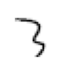

In [946]:
n=24
show_image(incorrect[n].view(28,28))
print("guess: ", torch.argmax(badguesses[n]))
print("actual: ", correct[n])


preds:  tensor([[ -33.0913, -101.7266, -130.7633,  -61.0670,  190.0876,   59.2970,  -88.8163,   11.2021,   17.7532,  118.9505]], grad_fn=<AddBackward0>)
tensor([4])


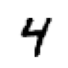

In [785]:
t = training_sample(1)

for (d,y) in t:
    p = simple_net(d)
    #print(d.shape)
    show_image(d.view(28,28))
    print("preds: ", p)
    print(y)

In [912]:
# training loop
#https://stackoverflow.com/questions/60032073/select-specific-rows-of-2d-pytorch-tensor


#def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()
#def linear1(xb): return xb@weights + bias


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

lr = 0.08
num=1
size=3000
# train
def train_model(size, model, params, lr, num):
    for i in range(num):
        train_epoch(size, model, lr, params)
       


#print(params)
train_model(size, simple_net, params, lr, num)







tensor(0.9093)
loss:  tensor(3.1909, grad_fn=<NllLossBackward>)


In [730]:
# write out model to disk
import pickle

def save_model():
    model = {'w1':w1, 'b1': b1, 'w2':w2, 'b2': b2}
    with open('mymodel.pkl', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_model():
    with open('filename.pickle', 'rb') as handle:
        model = pickle.load(handle)
    w1 = model['w1']
    b1 = model['b1']
    w2 = model['w2']
    b2 = model['b2']


    
save_model()


